In [41]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure
from scipy.stats import wasserstein_distance

import torch

import random
import copy
import math
import cv2
import os
import sys

# TRAINED MODELS
## Variables definition

In [42]:
div = 64
step = int(32/4)
red = 1

n_crops = 500

box = 4
kernel = np.ones((box,box),np.float32)/(box**2)

map_list_t = ['master_big','master_big_closed','master_big_semiclosed']
map_root_name = 'master_big'
# map_list = ['map2','stanford_hyang10','master_big','willow','costacafe','map1','map3','stanford_coupa0', 'stanford_coupa3','stanford_hyang1','stanford_gates2']
map_list = ['stanford_bookstore0', 'stanford_bookstore4', 'stanford_coupa0', 'stanford_coupa1', 
            'stanford_coupa2', 'stanford_coupa3', 'stanford_gates1', #, 'stanford_gates0'
            'stanford_gates2', 'stanford_gates3', 'stanford_hyang2', 'stanford_hyang3', 
            'stanford_hyang4',  'stanford_hyang10', 'stanford_little3',  'stanford_nexus0',  
            'stanford_nexus1',  'stanford_deathCircle0']

# sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection','shadow']
sem_dict = ['bicycle_road', 'building', 'entrance', 'grass', 'obstacle', 'parking', 'pedestrian_road', 'tree', 'vehicle_road']
chans = len(sem_dict)

lut_in = [0, 20, 50, 100, 150, 255]
lut_out = [0, 100, 180, 220, 240, 255]
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

# Loading of the models

In [43]:
# spec = 'stan'
# date = '01feb'

# model = tf.keras.models.load_model('IRI_models/'+date+'_'+str(step)+'px_steps_'+spec+'_paths')

# model1 = tf.keras.models.load_model('IRI_models/'+date+'_8px_steps_'+spec+'_vels')

# model2 = tf.keras.models.load_model('IRI_models/'+date+'_8px_steps_'+spec+'_stops')

## Testing closed corridors (completely or partially closed)

In [44]:
# for map_name in map_list_t:
#   print(map_name)

#   lines = 0
#   with open('maps/semantics/'+map_root_name+'/'+map_name+'.csv') as f:
#     lines = f.readlines()

#   h = len(lines)
#   w = len(lines[0].split(','))

#   # Converts data to a list of integers
#   map = []
#   for line in lines:
#     map.extend([int(c) for c in line.split(',')])

#   for lab_class in sem_dict:
#     lines = 0
#     try:
#       with open('maps/semantics/'+map_root_name+'/'+map_root_name+'_sem_'+lab_class+'.csv') as f:
#         lines = f.readlines()

#       hh = len(lines)
#       ww = len(lines[0].split(','))

#       if hh != h or ww != w:
#         print(f'h: {h}\tw: {w}')
#         print(f'h: {hh}\tw: {ww}')
#         raise SystemExit("ERROR: Different sizes!!")

#       # Converts data to a list of integers
#       for line in lines:
#         map.extend([int(c) for c in line.split(',')])

#     except FileNotFoundError:
#       for i in range(h):
#         for j in range(w):
#           map.extend([255])

#   map = np.reshape(map,[chans,h,w])
#   map = np.moveaxis(map, 0, -1)
#   map = map/255

#   map_aux = map
#   map = np.zeros((int(math.ceil(h/2)),int(math.ceil(w/2)),chans))

#   for idx in range(chans):
#     map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (2,2), np.max)
#   h, w, _ = map.shape

#   diff_h = int((h-div*int(h/div))/2)
#   r_h = int((h-div*int(h/div))%2) + diff_h
#   diff_w = int((w-div*int(w/div))/2)
#   r_w = int((w-div*int(w/div))%2) + diff_w
#   map = map[r_h:-diff_h:,r_w+diff_w:,:]

#   # print(map.shape)
#   h, w, _ = map.shape

#   # -----------------------------------------------------------------------------------
#   # creating subplot and figure
#   fig = plt.figure(figsize=(w/70,h/70))
#   data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

#   step = int(32/4)
#   for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
#     c = int(i%(w/step+int(div/step-1))) - int(div/step-1)*0
#     r = int(i/(w/step+int(div/step-1))) - int(div/step-1)*0
#     submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
#     subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
#     subdata = np.squeeze(subdata,axis=0)
#     data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
#   contrasted_data = cv2.LUT((data_pred/np.max(data_pred)*255).astype(np.uint8), lut_8u).astype(float)/255
#   plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(contrasted_data.shape,1),1-contrasted_data,1-contrasted_data),axis=2)), vmin=0, vmax=1)
#   # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
#   plt.show()

## Model 1 testing

stanford_bookstore0


libpng warning: iCCP: known incorrect sRGB profile


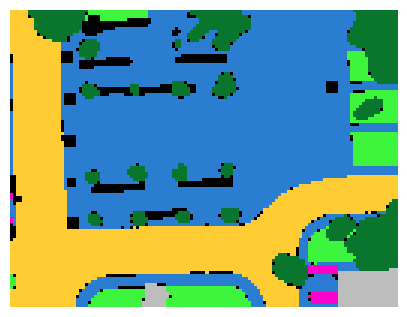

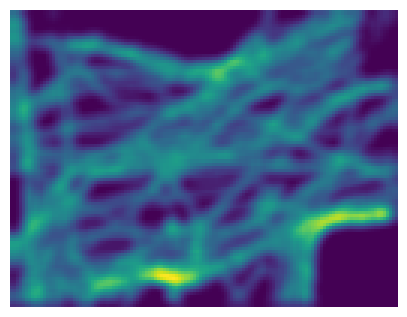

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


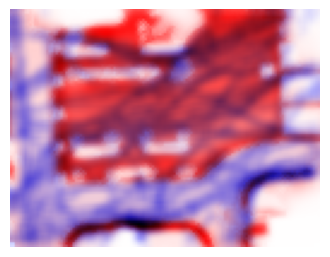

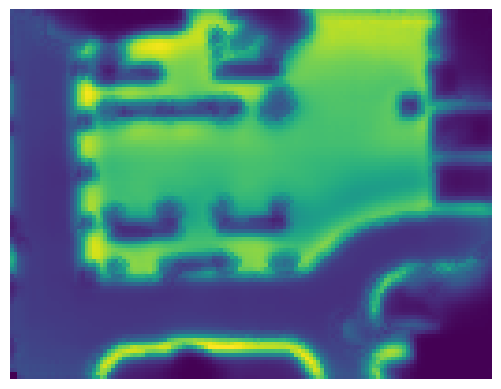

KL-divergence: 0.3871300220489502
Reverse KL-divergence: 1.3111839294433594
EMD: 23.45
MSE: 4.21e-09
stanford_bookstore4


libpng warning: iCCP: known incorrect sRGB profile


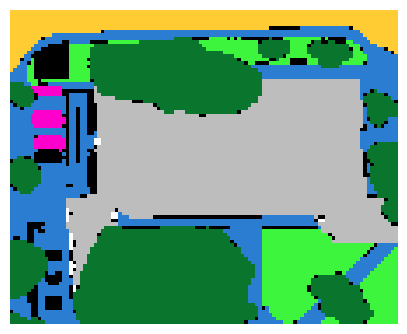

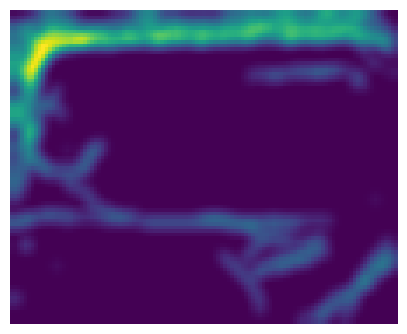

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


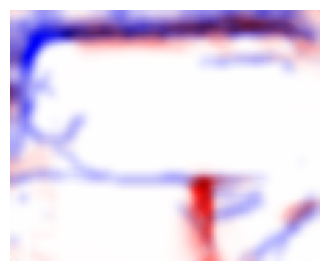

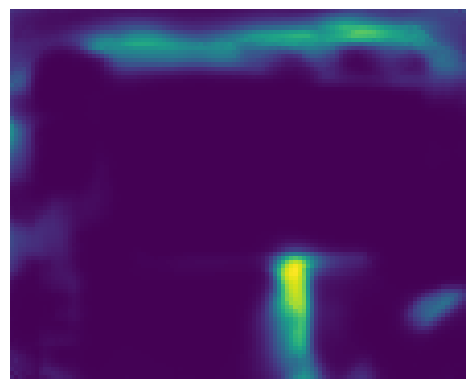

KL-divergence: 0.9206147193908691
Reverse KL-divergence: 1.9254734516143799
EMD: 11.91
MSE: 3.15e-08
stanford_coupa0


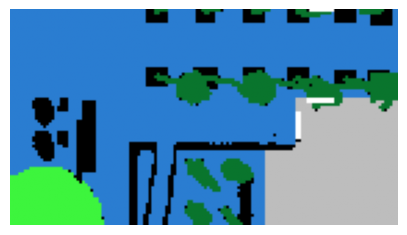

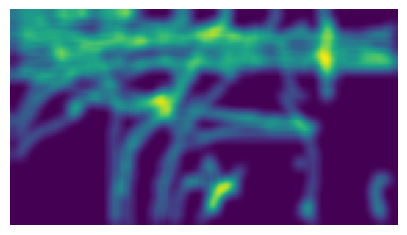

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


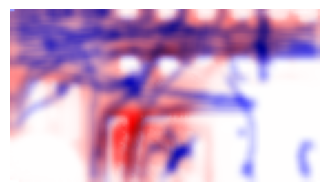

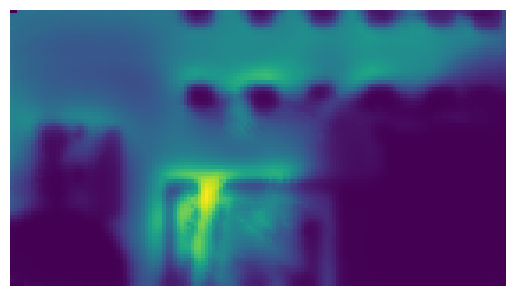

KL-divergence: 0.5126805305480957
Reverse KL-divergence: 1.7161670923233032
EMD: 14.00
MSE: 7.33e-09
stanford_coupa1


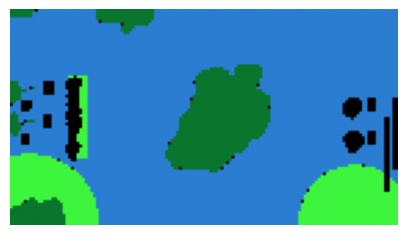

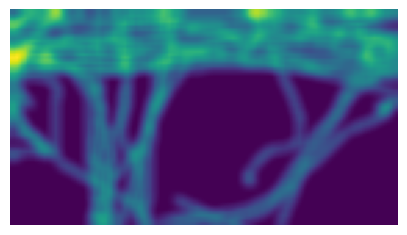

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


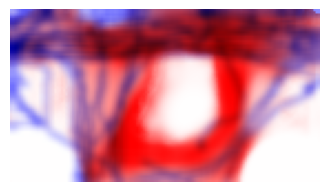

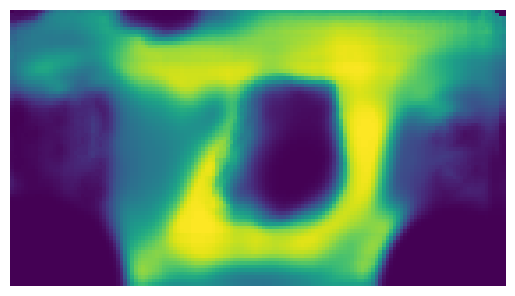

KL-divergence: 0.5976136326789856
Reverse KL-divergence: 3.016030788421631
EMD: 20.65
MSE: 7.96e-09
stanford_coupa2


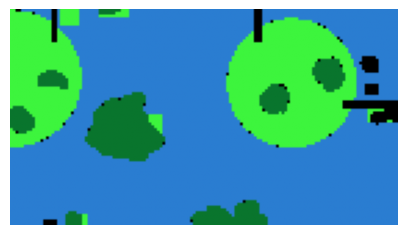

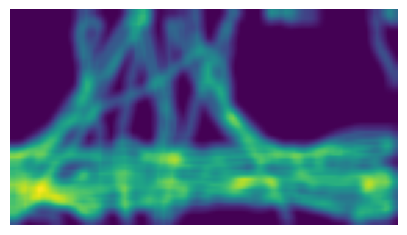

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


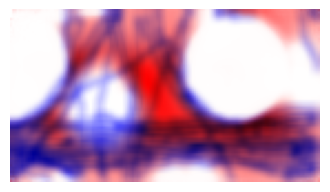

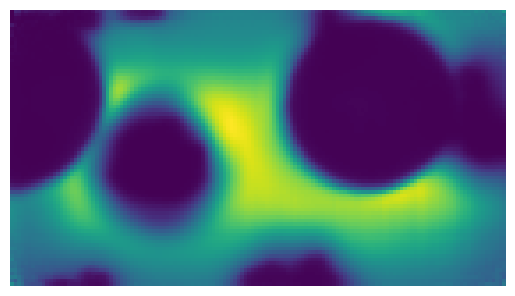

KL-divergence: 0.4111826717853546
Reverse KL-divergence: 1.1568081378936768
EMD: 17.35
MSE: 6.02e-09
stanford_coupa3


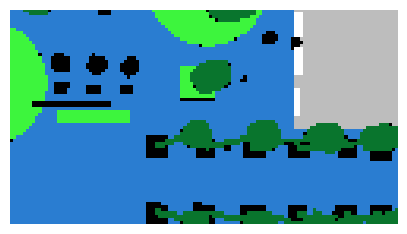

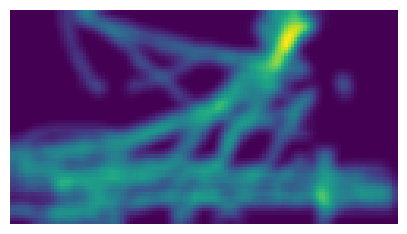

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


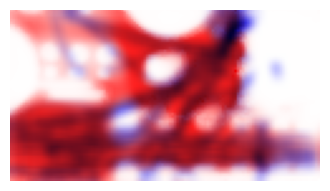

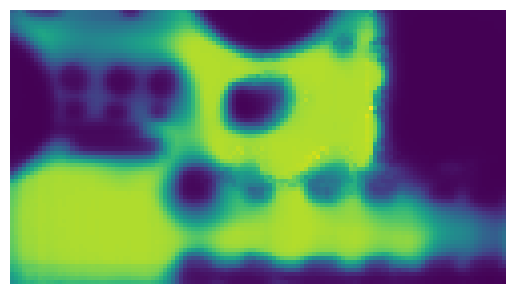

KL-divergence: 0.2842113673686981
Reverse KL-divergence: 1.1683263778686523
EMD: 20.34
MSE: 7.22e-09
stanford_gates1


libpng warning: iCCP: known incorrect sRGB profile


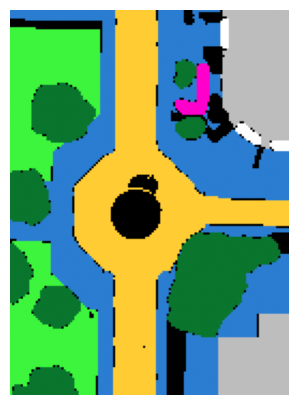

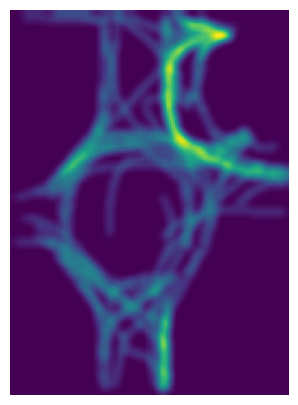

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


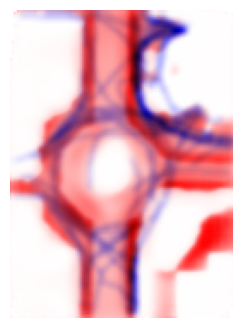

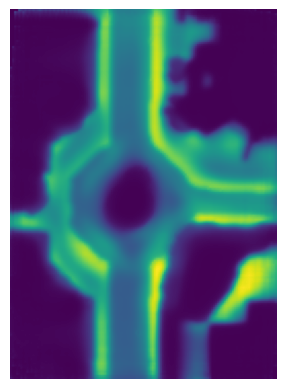

KL-divergence: 0.6781666278839111
Reverse KL-divergence: 4.334987163543701
EMD: 75.20
MSE: 3.76e-09
stanford_gates2


libpng warning: iCCP: known incorrect sRGB profile


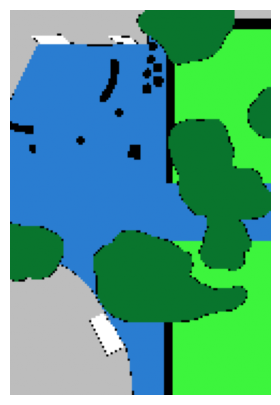

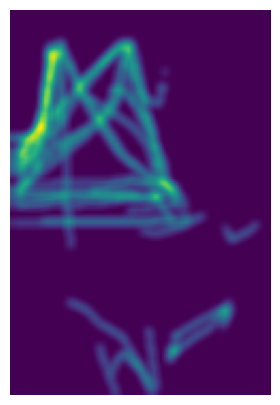

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


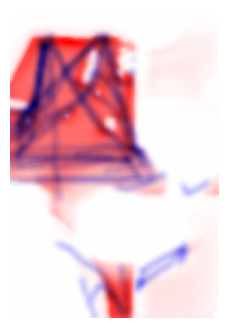

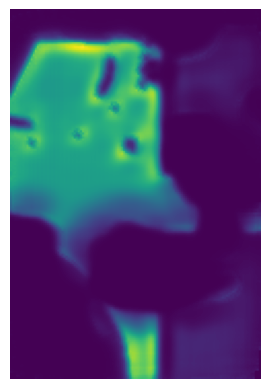

KL-divergence: 0.6332435607910156
Reverse KL-divergence: 3.7281484603881836
EMD: 54.16
MSE: 4.05e-09
stanford_gates3


libpng warning: iCCP: known incorrect sRGB profile


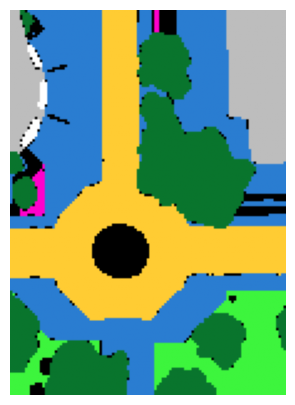

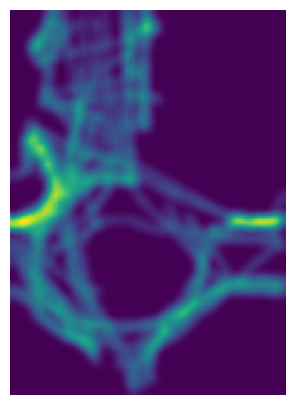

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


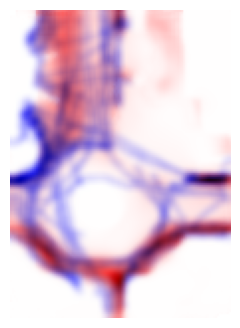

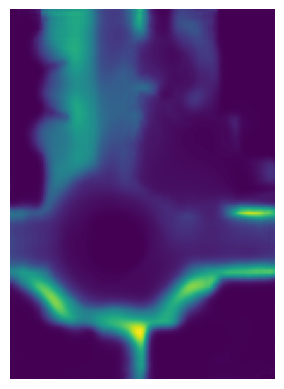

KL-divergence: 0.4926110804080963
Reverse KL-divergence: 1.6269617080688477
EMD: 35.82
MSE: 4.18e-09
stanford_hyang2


libpng warning: iCCP: known incorrect sRGB profile


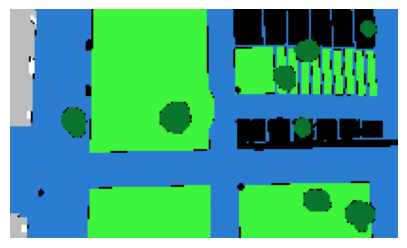

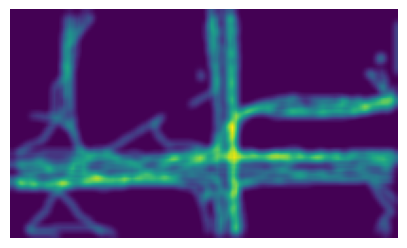

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


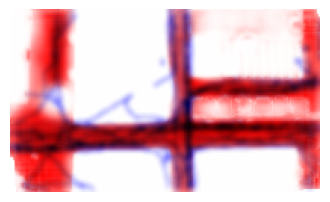

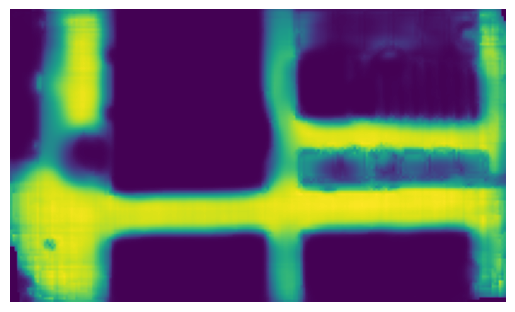

KL-divergence: 0.6044411659240723
Reverse KL-divergence: 2.909207820892334
EMD: 39.25
MSE: 1.82e-09
stanford_hyang3


libpng warning: iCCP: known incorrect sRGB profile


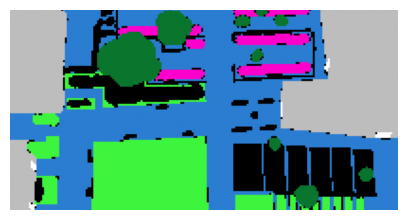

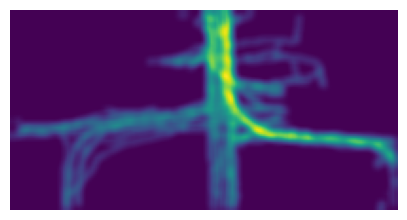

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


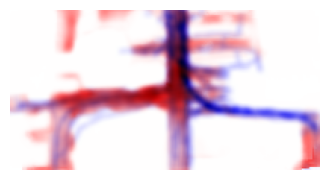

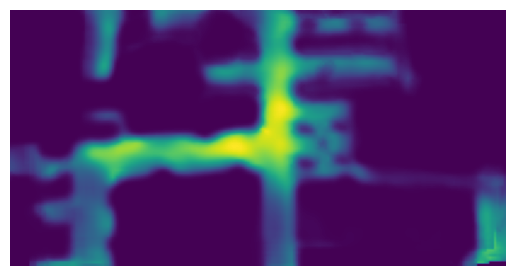

KL-divergence: 0.6873345971107483
Reverse KL-divergence: 2.4401323795318604
EMD: 21.62
MSE: 4.37e-09
stanford_hyang4


libpng warning: iCCP: known incorrect sRGB profile


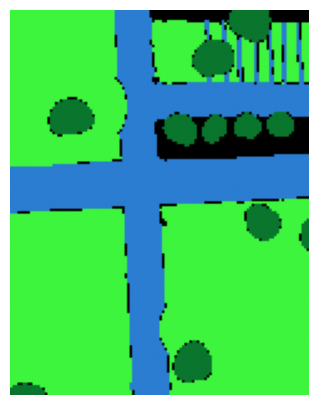

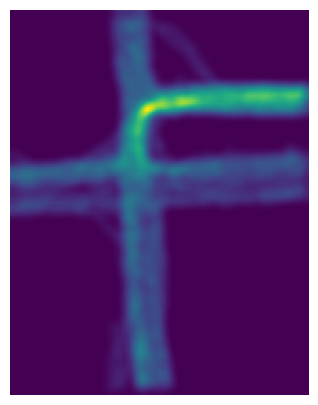

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


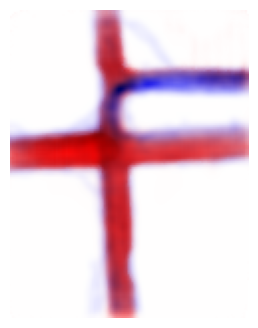

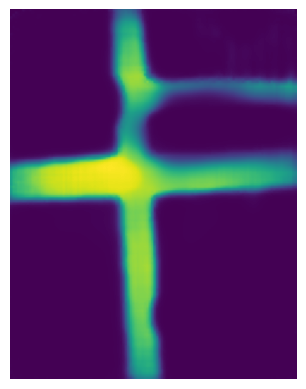

KL-divergence: 0.5437833070755005
Reverse KL-divergence: 0.47214025259017944
EMD: 28.93
MSE: 6.42e-09
stanford_hyang10


libpng warning: iCCP: known incorrect sRGB profile


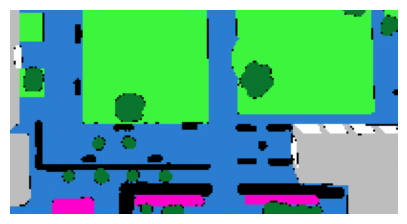

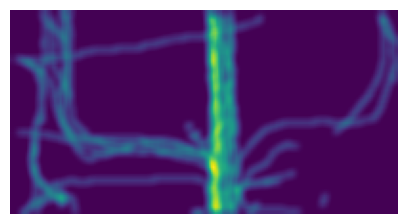

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


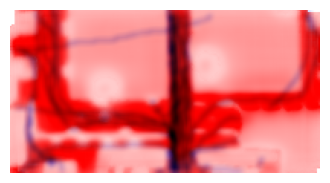

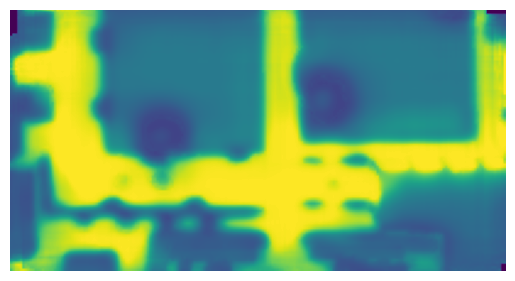

KL-divergence: 0.8741700649261475
Reverse KL-divergence: 7.227889060974121
EMD: 88.52
MSE: 5.40e-09
stanford_little3


libpng warning: iCCP: known incorrect sRGB profile


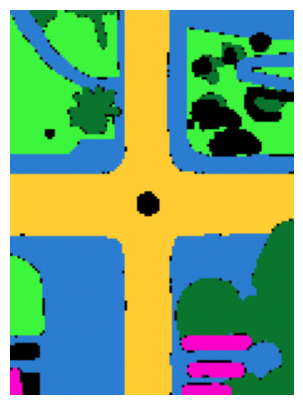

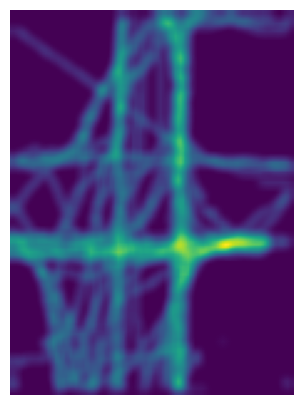

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


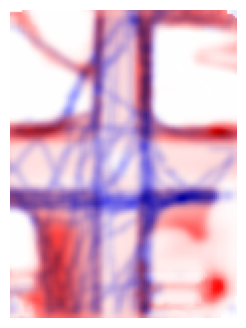

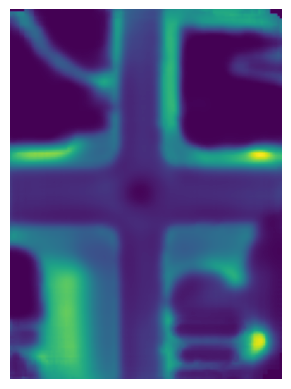

KL-divergence: 0.5287694334983826
Reverse KL-divergence: 2.9238946437835693
EMD: 29.54
MSE: 4.03e-09
stanford_nexus0


libpng warning: iCCP: known incorrect sRGB profile


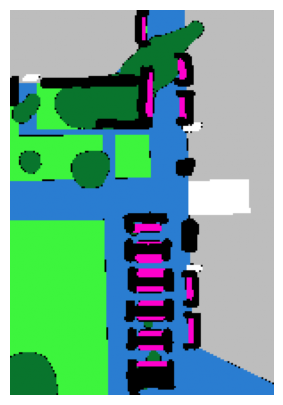

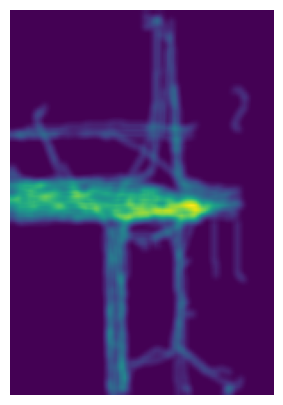

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


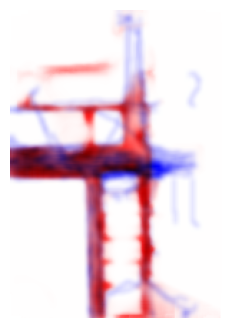

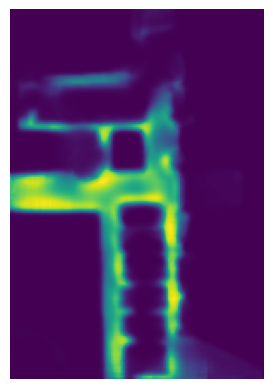

KL-divergence: 0.8241050243377686
Reverse KL-divergence: 1.8688757419586182
EMD: 40.54
MSE: 2.03e-09
stanford_nexus1


libpng warning: iCCP: known incorrect sRGB profile


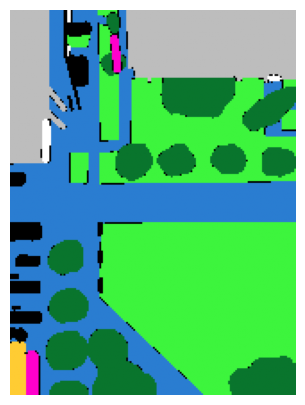

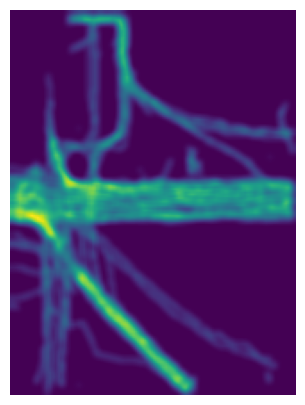

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


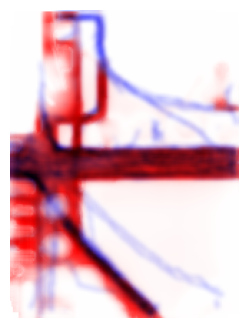

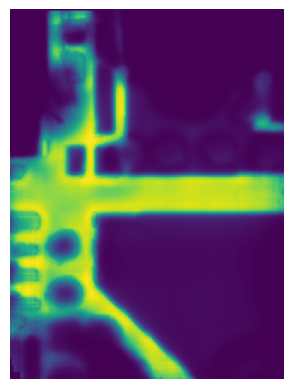

KL-divergence: 0.6229416728019714
Reverse KL-divergence: 2.217266321182251
EMD: 82.12
MSE: 1.07e-09
stanford_deathCircle0


libpng warning: iCCP: known incorrect sRGB profile


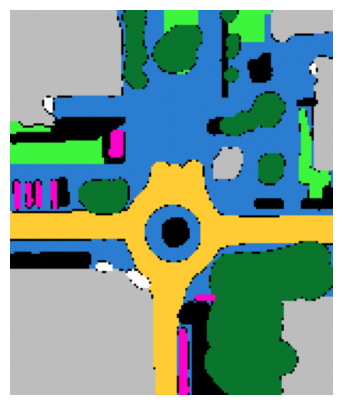

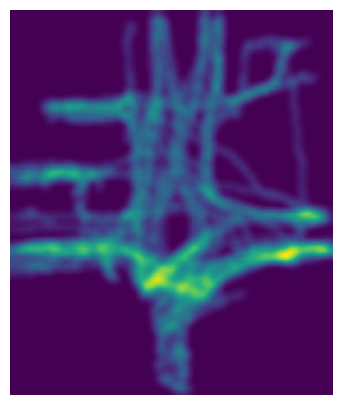

/tmp/ipykernel_2001593/1662283598.py:112: RuntimeWarning: divide by zero encountered in divide
  selections = 1/selections


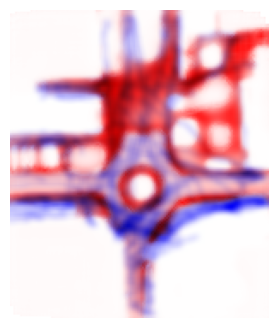

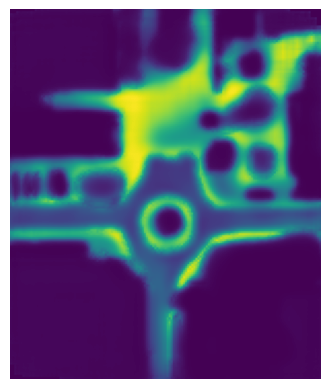

KL-divergence: 0.7994576692581177
Reverse KL-divergence: 2.3925137519836426
EMD: 89.34
MSE: 2.63e-09
-----------------------------
Mean KL-divergence: 0.6119092439903933
Std KL-divergence: 0.16960712619358015
Mean reverse KL-divergence: 2.4962357107330773
Std reverse KL-divergence: 1.5174422781618027
Mean EMD: 4.07e+01
Std EMD: 2.61e+01


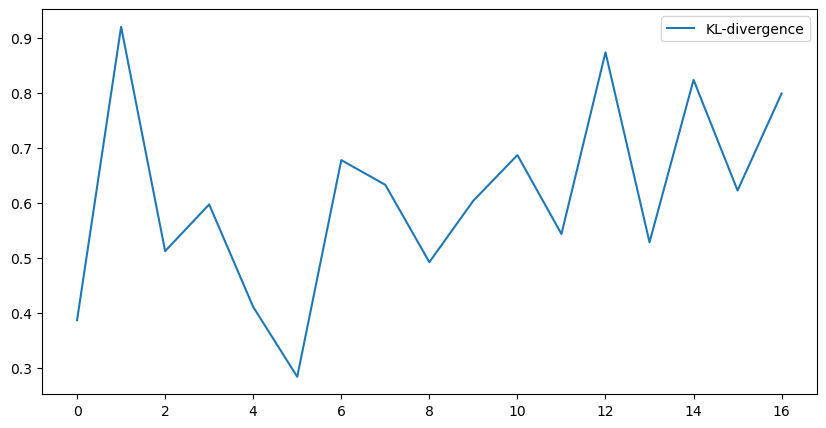

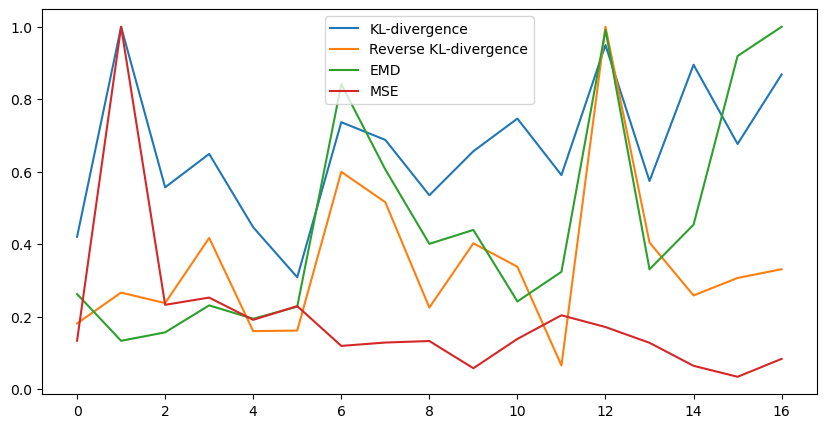

In [45]:
kl1 = []
kli1 = []
was1 = []
mse1 = []

if True:
  map_name = 'stanford_nexus0'

for map_count, map_name in enumerate(map_list):
  print('\n\n-----------------------------\n')
  print(map_name)

  model = tf.keras.models.load_model('IRI_models/final6/9labels_'+map_name)

  # -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([float(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  data = skimage.measure.block_reduce(data, (red,red), np.max)

  # print(data.shape)
  hd, wd = data.shape
  
  data_show = data
  data_show = cv2.filter2D(data_show,-1,kernel)
  data_show = cv2.filter2D(data_show,-1,kernel)
  data = data_show/np.sum(data_show)
  data_show = data_show/np.max(data_show)

  # -----------------------------------------------------------------------------------

  png_path = 'maps/semantics/'+map_name+'/'+map_name+'_colors.png'
  labelmap_path = 'maps/semantics/labelmap.txt'

  # Read the labelmap file
  with open(labelmap_path, 'r') as f:
      labelmap = f.readlines()
  labelmap.pop(0)
  labelmap.pop(0)

  # Load the PNG image
  image = cv2.imread(png_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (wd,hd), interpolation = cv2.INTER_LINEAR)
  map = np.zeros((hd,wd,chans))

  # fig = plt.figure(figsize=(5,5))
  # plt.imshow(image)
  # plt.axis('off')
  # plt.show()

  colors = []
  # Iterate over each label in the labelmap
  for i, label in enumerate(labelmap):
      label = label.strip().split(':')
      label_name = label[0]
      label_color = np.array(label[1].split(','), dtype=int)
      colors.append(label_color)
      # Create a mask for the pixels with the label color
      map[:,:,i] = 255-cv2.inRange(image, label_color-10, label_color+10)

  map = map/255

  # print(map.shape)
  h, w, _ = map.shape

  sem_map = np.zeros((h,w,3))
  for i in range(len(sem_dict)):
    sem = np.full((h,w,3),colors[i])
    sem_map = np.stack((1-map[:,:,i],1-map[:,:,i],1-map[:,:,i]), axis=2)*sem+sem_map
  fig = plt.figure(figsize=(5,5))
  plt.imshow(sem_map/255)
  plt.axis('off')
  plt.show()

  fig = plt.figure(figsize=(5,5))
  plt.imshow(data_show)
  plt.axis('off')
  plt.show()

  # -----------------------------------------------------------------------------------
  # Random sample 32x32 windows in map
  inserted = 0
  crops = np.zeros((n_crops,2),dtype=int)
  selections = np.zeros((h,w))
  for i in range(n_crops):
    background = np.zeros((h,w))
    flag = True
    while flag:
      aux_x = int(random.random()*(w-div+1))
      aux_y = int(random.random()*(h-div+1))
      flag = False
      # print(f'INSERTED: {inserted}  ->  x: {aux_x} and y: {aux_y}')
      # for z in range(inserted):
      #   if abs(aux_x-crops[z,0])<int(div/10) and abs(aux_y-crops[z,1])<int(div/10):
      #     # print('too close')
      #     flag = True
    crops[i,0] = aux_x
    crops[i,1] = aux_y
    selections = selections+cv2.rectangle(background,(crops[i,0],crops[i,1]),(crops[i,0]+div-1,crops[i,1]+div-1),(1,0,0),-1)
    inserted = inserted + 1
  selections = 1/selections

  # -----------------------------------------------------------------------------------
  # creating subplot and figure
  # ax = plt.subplot(111)
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
  kls = []
  for i in range(n_crops):
    submap = map[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div,:]
    data_aux = data[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
    subdata = np.squeeze(subdata,axis=0)
    data_pred[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    # Calculate the KL-divergence
    
  data = torch.Tensor(data)
  data_pred = torch.Tensor(data_pred)
  data = data/data.sum()
  data_pred = data_pred/data_pred.sum()
  data_pred[data_pred == 0] = 1e-12
  data_pred[data_pred == 1] = 1-1e-12
  data[data == 0] = 1e-12
  data[data == 1] = 1-1e-12

  kl = torch.nn.functional.kl_div(data_pred.unsqueeze(0).log(), data.unsqueeze(0), reduction='batchmean').item()
  kli = torch.nn.functional.kl_div(data.unsqueeze(0).log(), data_pred.unsqueeze(0), reduction='batchmean').item()
  h, w = data.shape
  data_aux = (data / data.max() * 255).detach().cpu().numpy().astype(int)
  pred_aux = (data_pred / data_pred.max() * 255).detach().cpu().numpy().astype(int)
  hist_a = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist_a[data_aux[i, j]] += 1
  hist_b = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist_b[pred_aux[i, j]] += 1
  was = wasserstein_distance(hist_a, hist_b)
  mse = ((data - data_pred)**2).mean()

  data = data/data.max()
  data_pred = data_pred/data_pred.max()
  plt.figure(figsize=(4,4))
  plt.imshow(np.multiply(np.stack((1-data,1-data,np.full(data.shape,1)),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)))
  plt.axis('off')
  plt.show()
  
  data_pred = data_pred/np.max(data_pred.detach().cpu().numpy())
  plt.imshow(data_pred)
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
  plt.axis('off')
  plt.show()

  print(f'KL-divergence: {kl}')
  print(f'Reverse KL-divergence: {kli}')
  print(f'EMD: {was:.2f}')
  print(f'MSE: {mse:.2e}')
  kl1 = np.append(kl1,kl)
  kli1 = np.append(kli1,kli)
  was1 = np.append(was1,was)
  mse1 = np.append(mse1,mse)
  # import sys
  # sys.exit(0)

print('-----------------------------')
print(f'Mean KL-divergence: {np.mean(kl1)}')
print(f'Std KL-divergence: {np.std(kl1)}')
print(f'Mean reverse KL-divergence: {np.mean(kli1)}')
print(f'Std reverse KL-divergence: {np.std(kli1)}')
print(f'Mean EMD: {np.mean(was1):.2e}')
print(f'Std EMD: {np.std(was1):.2e}')

# plot KL-div
plt.figure(figsize=(10,5))
plt.plot(kl1, label='KL-divergence')
plt.legend()
plt.show()

# plot all metrics normalized
plt.figure(figsize=(10,5))
plt.plot(kl1 / np.max(kl1), label='KL-divergence')
plt.plot(kli1 / np.max(kli1), label='Reverse KL-divergence')
plt.plot(was1 / np.max(was1), label='EMD')
plt.plot(mse1 / np.max(mse1), label='MSE')
plt.legend()
plt.show()